
<CENTER><img src=https://upload.wikimedia.org/wikipedia/commons/8/84/URJC_logo.svg></CENTER>


 
## <center>  ANÁLISIS DEL ESTADO ANÍMICO DE LA SOCIEDAD EN EL COVID-19 A TRAVÉS DE TWEETS

## Importamos los datos y las librerías

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from os import listdir, mkdir

import re
import string

In [ ]:
!pip install pyspark[sql]

from __future__ import print_function
from functools import wraps
import pyspark as spark
from pyspark import SparkConf
import time
from operator import add
import os 
from subprocess import STDOUT, check_call, check_output

In [ ]:
def setup_sra_tool(url):
  !wget $url
  !gunzip sratoolkit.2.9.6-1-ubuntu64.tar.gz
  !tar -xf sratoolkit.2.9.6-1-ubuntu64.tar
  
#download SRA file and extract fastq
def get_sra(url, sra_path):
  os.chdir('/content')
  !wget $url
  sra_name = url[-11:]
  os.chdir(sra_path)
  !./fastq-dump /content/$sra_name -O /content/
  os.chdir('/content')
  
# url of SRA tool kit 
url_tk= 'https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/2.9.6-1/sratoolkit.2.9.6-1-ubuntu64.tar.gz'
setup_sra_tool(url_tk)


--2021-05-02 09:18:38--  https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/2.9.6-1/sratoolkit.2.9.6-1-ubuntu64.tar.gz
Resolving ftp-trace.ncbi.nlm.nih.gov (ftp-trace.ncbi.nlm.nih.gov)... 165.112.9.228, 165.112.9.229, 2607:f220:41e:250::12, ...
Connecting to ftp-trace.ncbi.nlm.nih.gov (ftp-trace.ncbi.nlm.nih.gov)|165.112.9.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84492294 (81M) [application/x-gzip]
Saving to: ‘sratoolkit.2.9.6-1-ubuntu64.tar.gz.1’

 sratoolkit.2.9.6-1  61%[===========>        ]  49.38M  24.8MB/s               ^C
gzip: sratoolkit.2.9.6-1-ubuntu64.tar already exists; do you wish to overwrite (y or n)? n
	not overwritten


In [ ]:
def set_conf():
    conf = SparkConf().setAppName("App")
    conf = (conf.setMaster('local[*]')
      .set('spark.executor.memory', '4G')
      .set('spark.driver.memory', '16G')
      .set('spark.driver.maxResultSize', '8G'))
    return conf

In [ ]:
sc = spark.SparkContext.getOrCreate(conf=set_conf())

In [ ]:
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
dir = "/content/drive/MyDrive/MI_PMD/"
folders = os.listdir(dir)
print(folders)

['Corona_NLP_test.csv', '.ipynb_checkpoints', 'Corona_NLP_train.csv']


## Datos

In [ ]:
df_train = pd.read_csv(dir+"Corona_NLP_train.csv",encoding = "IBM437")
df_test = pd.read_csv(dir+"Corona_NLP_test.csv",encoding = "IBM437")

In [ ]:
#df_train=sc.textFile(dir+"Corona_NLP_train.csv")
#df_test=sc.textFile(dir+"Corona_NLP_test.csv")


In [ ]:
df_train = pd.read_csv("Corona_NLP_train.csv",encoding = "IBM437")
df_test = pd.read_csv("Corona_NLP_test.csv",encoding = "IBM437")


https://docs.python.org/3/library/codecs.html#standard-encodings 

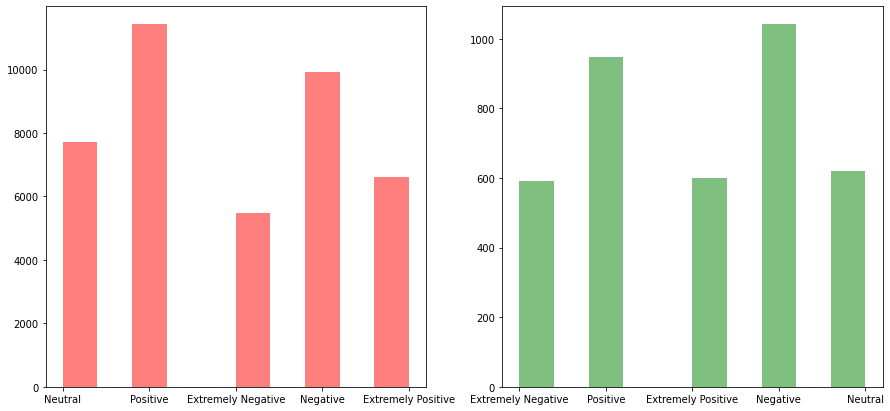

In [ ]:
#Mostramos gráficamente la distribución de los datos
fig, ax = plt.subplots(1,2,figsize=(15,7))
ax[0].hist(df_train["Sentiment"],alpha = 0.5, color = 'r')
ax[1].hist(df_test["Sentiment"],alpha = 0.5, color = 'g')
plt.show()

Analizamos la cantidad de valores nulos y a qué columnas afectan. Se puede ver que afecta únicamente a localización por lo que no tendría sentido eliminar aquellos usuarios de los que no tenemos localización cuando sí se puede realizar el objetivo principal del proyecto consistente en relacionar el tweet con los sentimientos expresados.

In [ ]:
df_train.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [ ]:
df_test.isnull().sum()

UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64

### Preprocesado de los datos

In [ ]:
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?¿\]\%', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
def clean_text_round2(text):
    '''Get rid of some additional punctuation and non-sensical text that was missed the first time around.'''
    text = re.sub('[‘’“”…«»]', '', text)
    text = re.sub('\n', ' ', text)
    return text
def eliminar_tilde(text):
    text=text.replace("á","a")
    text=text.replace("é","e")
    text=text.replace("í","i")
    text=text.replace("ó","o")
    text=text.replace("ú","u")
    return text

In [ ]:
for k in range(0,len(df_train['OriginalTweet'])):
    clean1=clean_text_round1(df_train['OriginalTweet'][k])
    clean2=clean_text_round2(clean1)
    df_train['OriginalTweet'][k]=eliminar_tilde(clean2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
for k in range(0,len(df_test['OriginalTweet'])):
    clean1=clean_text_round1(df_test['OriginalTweet'][k])
    clean2=clean_text_round2(clean1)
    df_test['OriginalTweet'][k]=eliminar_tilde(clean2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
print("")
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


texto = df_train.OriginalTweet.str.cat(sep=' ')

#function to split text into word
tokens = word_tokenize(texto)

vocabulary = set(tokens)
print("Cantidad de palabras distintas: ", len(vocabulary))


stop_words = set(stopwords.words('english'))
print("Ejemplos de stopwords:", list(stop_words)[0:10])
tokens = [w for w in tokens if not w in stop_words]
frequency_dist = nltk.FreqDist(tokens)
print("Diez palabras con mayor frecuencia: ", sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:10])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.

Cantidad de palabras distintas:  57451
Ejemplos de stopwords: ['being', 'i', 'own', "you've", 'under', 'so', "weren't", 'shouldn', "shan't", 'but']
Diez palabras con mayor frecuencia:  ['co', 'https', 'coronavirus', 'covid', 'prices', 'food', 'supermarket', 'store', 'grocery', 'people']


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
print("")
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


texto = df_test.OriginalTweet.str.cat(sep=' ')

#function to split text into word
tokens = word_tokenize(texto)

vocabulary = set(tokens)
print("Cantidad de palabras distintas: ", len(vocabulary))


stop_words = set(stopwords.words('english'))
print("Ejemplos de stopwords:", list(stop_words)[0:10])
tokens = [w for w in tokens if not w in stop_words]
frequency_dist = nltk.FreqDist(tokens)
print("Diez palabras con mayor frecuencia: ", sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:10])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!

Cantidad de palabras distintas:  11971
Ejemplos de stopwords: ['being', 'i', 'own', "you've", 'under', 'so', "weren't", 'shouldn', "shan't", 'but']
Diez palabras con mayor frecuencia:  ['covid', 'co', 'https', 'coronavirus', 'food', 'store', 'grocery', 'stock', 'people', 'amp']


In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
X_train=df_train["OriginalTweet"]
y_train=df_train["Sentiment"]
X_test=df_test["OriginalTweet"]
y_test=df_test["Sentiment"]

vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)

In [ ]:
dicccionario={"y":y_train,"x":train_vectors}
diccionario2={"y":y_test,"x":test_vectors}
a=pd.DataFrame.from_dict(dicccionario)
b=pd.DataFrame.from_dict(diccionario2)


In [ ]:
type(a)

pandas.core.frame.DataFrame

In [ ]:
X_df_train=a.to_csv(index=False, header=False)
X_df_test=b.to_csv(index=False, header=False)

In [ ]:
X_train=sc.textFile(X_df_train)
x_test=sc.textFile(X_df_test)

In [ ]:
type(X_train)

pyspark.rdd.RDD

# Spark

In [ ]:
pip install findspark

In [ ]:
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
import pandas as pd

# Create a spark session
spark = SparkSession.builder.getOrCreate()

In [ ]:
import numpy as np
import pandas as pd

# Enable Arrow-based columnar data transfers
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

# Generate a pandas DataFrame
pdf = pd.DataFrame(np.random.rand(100, 3))

# Create a Spark DataFrame from a pandas DataFrame using Arrow
df = spark.createDataFrame(pdf)

# Convert the Spark DataFrame back to a pandas DataFrame using Arrow
result_pdf = df.select("*").toPandas()

AttributeError: ignored

In [ ]:
from pyspark.sql import SQLContext

sqlContext = SQLContext(sc)
sqlContext.createDataFrame(a)

TypeError: ignored

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Load training data
data = spark.read.format("libsvm").load("data/mllib/sample_multiclass_classification_data.txt")

# Split the data into train and test
splits = data.randomSplit([0.6, 0.4], 1234)
train = splits[0]
test = splits[1]

# specify layers for the neural network:
# input layer of size 4 (features), two intermediate of size 5 and 4
# and output of size 3 (classes)
layers = [4, 5, 4, 3]

# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234)

# train the model
model = trainer.fit(train)

# compute accuracy on the test set
result = model.transform(test)
predictionAndLabels = result.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Test set accuracy = " + str(evaluator.evaluate(predictionAndLabels)))

AttributeError: ignored

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
layers = [4, 5, 4, 3]

# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234)

# train the model
model = trainer.fit(X_train)

# compute accuracy on the test set
result = model.transform(x_test)
predictionAndLabels = result.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")


AttributeError: ignored

In [ ]:
from pyspark.mllib.classification import NaiveBayes, NaiveBayesModel
from pyspark.mllib.util import MLUtils



# Load and parse the data file.
#data = MLUtils.loadLibSVMFile(sc, "data/mllib/sample_libsvm_data.txt")

# Split data approximately into training (60%) and test (40%)
training, test = X_train.randomSplit([0.6, 0.4])

# Train a naive Bayes model.
model = NaiveBayes.train(training, 1.0)

# Make prediction and test accuracy.
predictionAndLabel = test.map(lambda p: (model.predict(p.features), p.label))
accuracy = 1.0 * predictionAndLabel.filter(lambda pl: pl[0] == pl[1]).count() / test.count()
print('model accuracy {}'.format(accuracy))

Py4JJavaError: ignored